In [49]:
import torch
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import numpy as np
import torchsummary
from livelossplot import PlotLosses
%matplotlib inline

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [51]:
class Vehicle(Dataset):
    def __init__(self, vehicles, labels):
        self.vehicles = vehicles
        self.labels = labels
    
    def __len__(self):
        return len(self.vehicles)

    # required function for accessing data
    def __getitem__(self, idx):
        return self.vehicles[idx], self.labels[idx]

In [52]:
root = os.getcwd() # current directory
images_directory = os.path.join(root, "vehicle_classification")
images = []
labels = []
current_label = 0
for label in os.listdir(images_directory): #loop over every class
    if not label.startswith('.'): # skip hidden directories
        label_directory = os.path.join(images_directory, label)
        for pic in os.listdir(label_directory): 
            image = Image.open(os.path.join(label_directory, pic)) # load the data using the PIL library
            image_array = np.array(image)
            image_array = np.transpose(image_array, (2, 0, 1)) #make image channels-first, as this is what PyTorch supports
            images.append(image_array)
            labels.append(current_label)
        current_label += 1 
images = np.array(images)
labels = np.array(labels)
classes = np.unique(labels) # list of classes

In [53]:
num_classes = len(classes)
image_height, image_length = len(images[0][0]), len(images[0][0][0])
print(f"There are {len(images)} images in the dataset")
print(f"Each image has dimensions {image_length}x{image_height}")
print(f"The total number of classes is {num_classes}")

There are 26378 images in the dataset
Each image has dimensions 64x64
The total number of classes is 8


In [54]:
X_train, X_test, y_train, y_test = train_test_split(
images, labels, test_size=0.20, random_state=42) #split into random train and test sets
X_train = torch.tensor(X_train).to(device)
X_test = torch.tensor(X_test).to(device)
y_train = torch.tensor(y_train).type(torch.LongTensor).to(device)
y_test = torch.tensor(y_test).type(torch.LongTensor).to(device)

In [55]:
batch_size = 64
kernel_size = 3
train_dataloader = DataLoader(Vehicle(X_train, y_train), batch_size=batch_size)
test_dataloader = DataLoader(Vehicle(X_test, y_test), batch_size=batch_size)

In [56]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        modules = []
        modules.append(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=kernel_size, padding='same')) 
        modules.append(
            nn.Dropout(0.5)) # some inputs are randomly dropped
        modules.append(
            nn.ReLU())
        modules.append(
            nn.MaxPool2d(kernel_size=kernel_size * 2))
        
        modules.append(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=kernel_size, padding='same')) 
        modules.append(
            nn.Dropout(0.5)) # some inputs are randomly dropped
        modules.append(
            nn.ReLU())
        modules.append(
            nn.MaxPool2d(kernel_size=kernel_size * 2)) 
        
        modules.append(nn.Flatten())
        modules.append(nn.Linear(16, 256)) # dense layer with 256 neurons 
        modules.append(nn.ReLU())
        modules.append(
            nn.Linear(256, num_classes))
        modules.append(
            nn.LogSoftmax(dim=1))
    
        self.network = nn.Sequential(*modules) # unpack the modules
    
    # Returns the summary of the model architecture given an input size
    def summary(self): 
        return torchsummary.summary(self, input_size=(3, image_height, image_length))
    
    def forward(self, x):
        prob = self.network(x)
        return prob

In [65]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    correct = 0
    total_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.type(torch.FloatTensor)
        # Compute prediction error
        pred = model(X).to(device)
        loss = loss_fn(pred, y).to(device)
        
        _, predicted = torch.max(pred.data, 1)
        correct += (predicted == y).sum().item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
            
            
    accuracy = correct / size
    average_loss = total_loss / num_batches # get average loss by dividing sum of losses by total batches
    return accuracy, average_loss
    

In [66]:
def test(dataloader, model, loss_fn, ):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.type(torch.FloatTensor)
            pred = model(X).to(device) # compute the model prediction
            
            # the predicted class is the one with the highest probability 
            # in the output distribution
            _, predicted = torch.max(pred.data, 1)
            correct += (predicted == y).sum().item()
            
            total_loss += loss_fn(pred, y).to(device).item()
            
    accuracy = correct / size
    average_loss = total_loss / num_batches # get average loss by dividing sum of losses by total batches
    
    return accuracy, average_loss

In [67]:
model = CNN()
model.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
           Dropout-2           [-1, 16, 64, 64]               0
              ReLU-3           [-1, 16, 64, 64]               0
         MaxPool2d-4           [-1, 16, 10, 10]               0
            Conv2d-5           [-1, 16, 10, 10]           2,320
           Dropout-6           [-1, 16, 10, 10]               0
              ReLU-7           [-1, 16, 10, 10]               0
         MaxPool2d-8             [-1, 16, 1, 1]               0
           Flatten-9                   [-1, 16]               0
           Linear-10                  [-1, 256]           4,352
             ReLU-11                  [-1, 256]               0
           Linear-12                    [-1, 8]           2,056
       LogSoftmax-13                    [-1, 8]               0
Total params: 9,176
Trainable params: 9

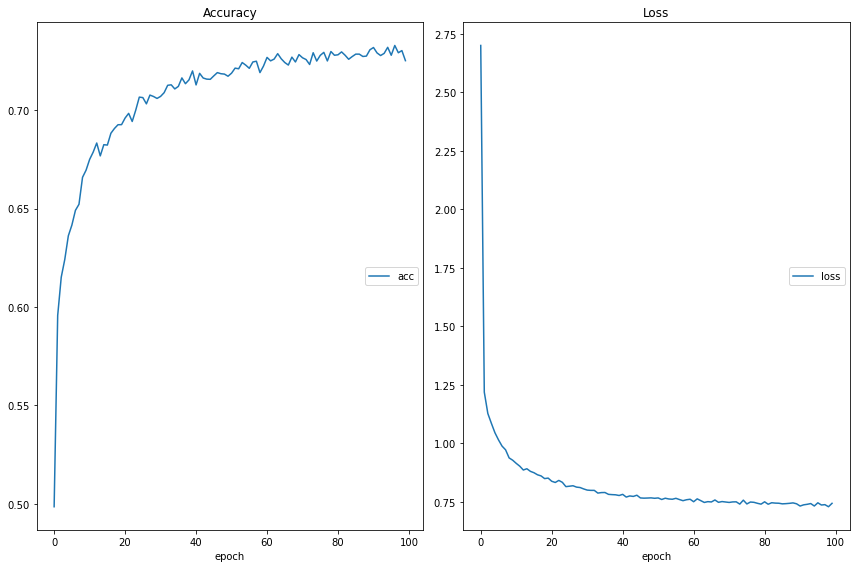

Accuracy
	acc              	 (min:    0.499, max:    0.733, cur:    0.725)
Loss
	loss             	 (min:    0.730, max:    2.701, cur:    0.744)
Done!


In [68]:
learning_rate = 0.001
loss_fn = nn.NLLLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loss, test_loss, train_acc, test_acc = [], [], [], []

epochs = 100
plotlosses = PlotLosses()

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    (train_acc, train_loss) = train(train_dataloader, model, loss_fn, optimizer)
    plotlosses.update({'acc': train_acc, 'loss': train_loss})
    plotlosses.send()
print("Done!")


In [71]:
(test_acc, test_loss) = test(test_dataloader, model, loss_fn)
print(f"The test loss is {test_loss}")
print(f"The test accuracy is {100 * test_acc}%")

The test loss is 1.1365822927061333
The test accuracy is 63.267626990144045%
